# "What factor is the most important for students’ academic performance?

By Daniel Truong and Emmanuel Wang

## Dataset

Kaggle dataset for Portugese students: https://www.kaggle.com/datasets/whenamancodes/student-performance

The reason we picked this data set was due to its high amount of features which include student grades, demographic information, social and school related features. They also provided two datasets, in two subjects so that can give a bit of an insight into how students perform in two subjects at a time.

## Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
file_path = "/content/drive/My Drive/CS463 Final Project/"
por_df = pd.read_csv(file_path + "student-por.csv", sep=";");
mat_df = pd.read_csv(file_path + "student-mat.csv", sep=";");

Mounted at /content/drive


## Exploratory Data Analysis

### About the Dataset

Let's start by analysing the dataset of Portugese students. The link for this dataset can be found here: https://www.kaggle.com/datasets/impapan/student-performance-data-set. In the given dataset, there are two csv files: one for a Math class and one for a Portugese class. We plan to to combine the two datasets into one unified student performance dataset. We hope that this will let us better analyze student performance across subjects.

Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:
1. school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
2. sex - student's sex (binary: 'F' - female or 'M' - male)
3. age - student's age (numeric: from 15 to 22)
4. address - student's home address type (binary: 'U' - urban or 'R' - rural)
5. famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
6. Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
7. Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)
8. Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)
9. Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
10. Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
11. reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
12. guardian - student's guardian (nominal: 'mother', 'father' or 'other')
13. traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
14. studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
15. failures - number of past class failures (numeric: n if 1<=n<3, else 4)
16. schoolsup - extra educational support (binary: yes or no)
17. famsup - family educational support (binary: yes or no)
18. paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
19. activities - extra-curricular activities (binary: yes or no)
20. nursery - attended nursery school (binary: yes or no)
21. higher - wants to take higher education (binary: yes or no)
22. internet - Internet access at home (binary: yes or no)
23. romantic - with a romantic relationship (binary: yes or no)
24. famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
25. freetime - free time after school (numeric: from 1 - very low to 5 - very high)
26. goout - going out with friends (numeric: from 1 - very low to 5 - very high)
27. Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
28. Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
29. health - current health status (numeric: from 1 - very bad to 5 - very good)
30. absences - number of school absences (numeric: from 0 to 93)

These grades are related with the course subject, Math or Portuguese:
31. G1 - first period grade (numeric: from 0 to 20)
31. G2 - second period grade (numeric: from 0 to 20)
32. G3 - final grade (numeric: from 0 to 20, output target)


### Merging the two datasets

With the instructions provided from the annaxed R file given by the dataset, we can combine the two of them using the code below.

In [ ]:
# Merging the two datasets
# Define the common columns to merge on
merge_cols = ["school", "sex", "age", "address", "famsize", "Pstatus", "Medu", "Fedu", "Mjob", "Fjob", "reason", "nursery", "internet"]
df = pd.merge(por_df, mat_df, on=merge_cols, suffixes=("", "_drop"))

# Make new columns for G1, G2 and G3 calculating the average of mat and por
df["G1"] = (df["G1"] + df["G1_drop"]) / 2
df["G2"] = (df["G2"] + df["G2_drop"]) / 2
df["G3"] = (df["G3"] + df["G3_drop"]) / 2
df = df[[col for col in df.columns if not col.endswith('_drop')]]

In [ ]:
pd.set_option('display.max_columns', None)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,2.5,8.5,8.5
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,7.0,8.0,8.5
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,9.5,10.5,11.0
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14.5,14.0,14.5
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,8.5,11.5,11.5


### Handling categorical values

We'll use one hot encoding for Mjob, Fjob, reason and guardian, and convert other categorical variables into numerical ones by assigning 0 or 1 to them, similar to Label Encoding.

In [ ]:
# One hot encoding
df = pd.get_dummies(df, columns=['Mjob', 'Fjob', 'reason', 'guardian'], drop_first=True)

In [ ]:
# # Converting categorical variables into numericals + dropping unnecessary columns
df = df.drop(columns=['school']) # Dropping school since school location should not affect much in our scope
df['sex'] = df['sex'].map({'F': 0, 'M': 1}) # Female: 0, Male: 1
df['address'] = df['address'].map({'U': 0, 'R': 1}) # Urban: 0, Rural: 1
df['famsize'] = df['famsize'].map({'LE3': 0, 'GT3': 1}) # Less than or equal to 3: 0, Greater than 3: 1
df['Pstatus'] = df['Pstatus'].map({'T': 0, 'A': 1}) # Together: 0, Apart: 1
df['schoolsup'] = df['schoolsup'].map({'no': 0, 'yes': 1}) # Extra educational support: 0 if no, 1 if yes
df['famsup'] = df['famsup'].map({'no': 0, 'yes': 1}) # Family educational support: 0 if no, 1 if yes
df['paid'] = df['paid'].map({'no': 0, 'yes': 1}) # Extra paid classes: 0 if no, 1 if yes
df['activities'] = df['activities'].map({'no': 0, 'yes': 1}) # Extracurricular activities: 0 if no, 1 if yes
df['nursery'] = df['nursery'].map({'no': 0, 'yes': 1}) # Attended nursery school: 0 if no, 1 if yes
df['higher'] = df['higher'].map({'no': 0, 'yes': 1}) # Wants to take higher education: 0 if no, 1 if yes
df['internet'] = df['internet'].map({'no': 0, 'yes': 1}) # Internet access at home: 0 if no, 1 if yes
df['romantic'] = df['romantic'].map({'no': 0, 'yes': 1}) # With a romantic relationship: 0 if no, 1 if yes

In [ ]:
# Resort dataset
g1_df = df['G1']
df = df.drop(columns=['G1'])
df['G1'] = g1_df
g2_df = df['G2']
df = df.drop(columns=['G2'])
df['G2'] = g2_df
g3_df = df['G3']
df = df.drop(columns=['G3'])
df['G3'] = g3_df

lasso_df = df

In [ ]:
print("Dataset:")
print(df.describe())

Dataset:
              sex         age     address     famsize     Pstatus        Medu  \
count  382.000000  382.000000  382.000000  382.000000  382.000000  382.000000   
mean     0.481675   16.586387    0.212042    0.727749    0.099476    2.806283   
std      0.500319    1.173470    0.409290    0.445702    0.299693    1.086381   
min      0.000000   15.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000   16.000000    0.000000    0.000000    0.000000    2.000000   
50%      0.000000   17.000000    0.000000    1.000000    0.000000    3.000000   
75%      1.000000   17.000000    0.000000    1.000000    0.000000    4.000000   
max      1.000000   22.000000    1.000000    1.000000    1.000000    4.000000   

             Fedu  traveltime   studytime    failures   schoolsup      famsup  \
count  382.000000  382.000000  382.000000  382.000000  382.000000  382.000000   
mean     2.565445    1.445026    2.039267    0.141361    0.130890    0.625654   
std      1.096240 

### Reducing features

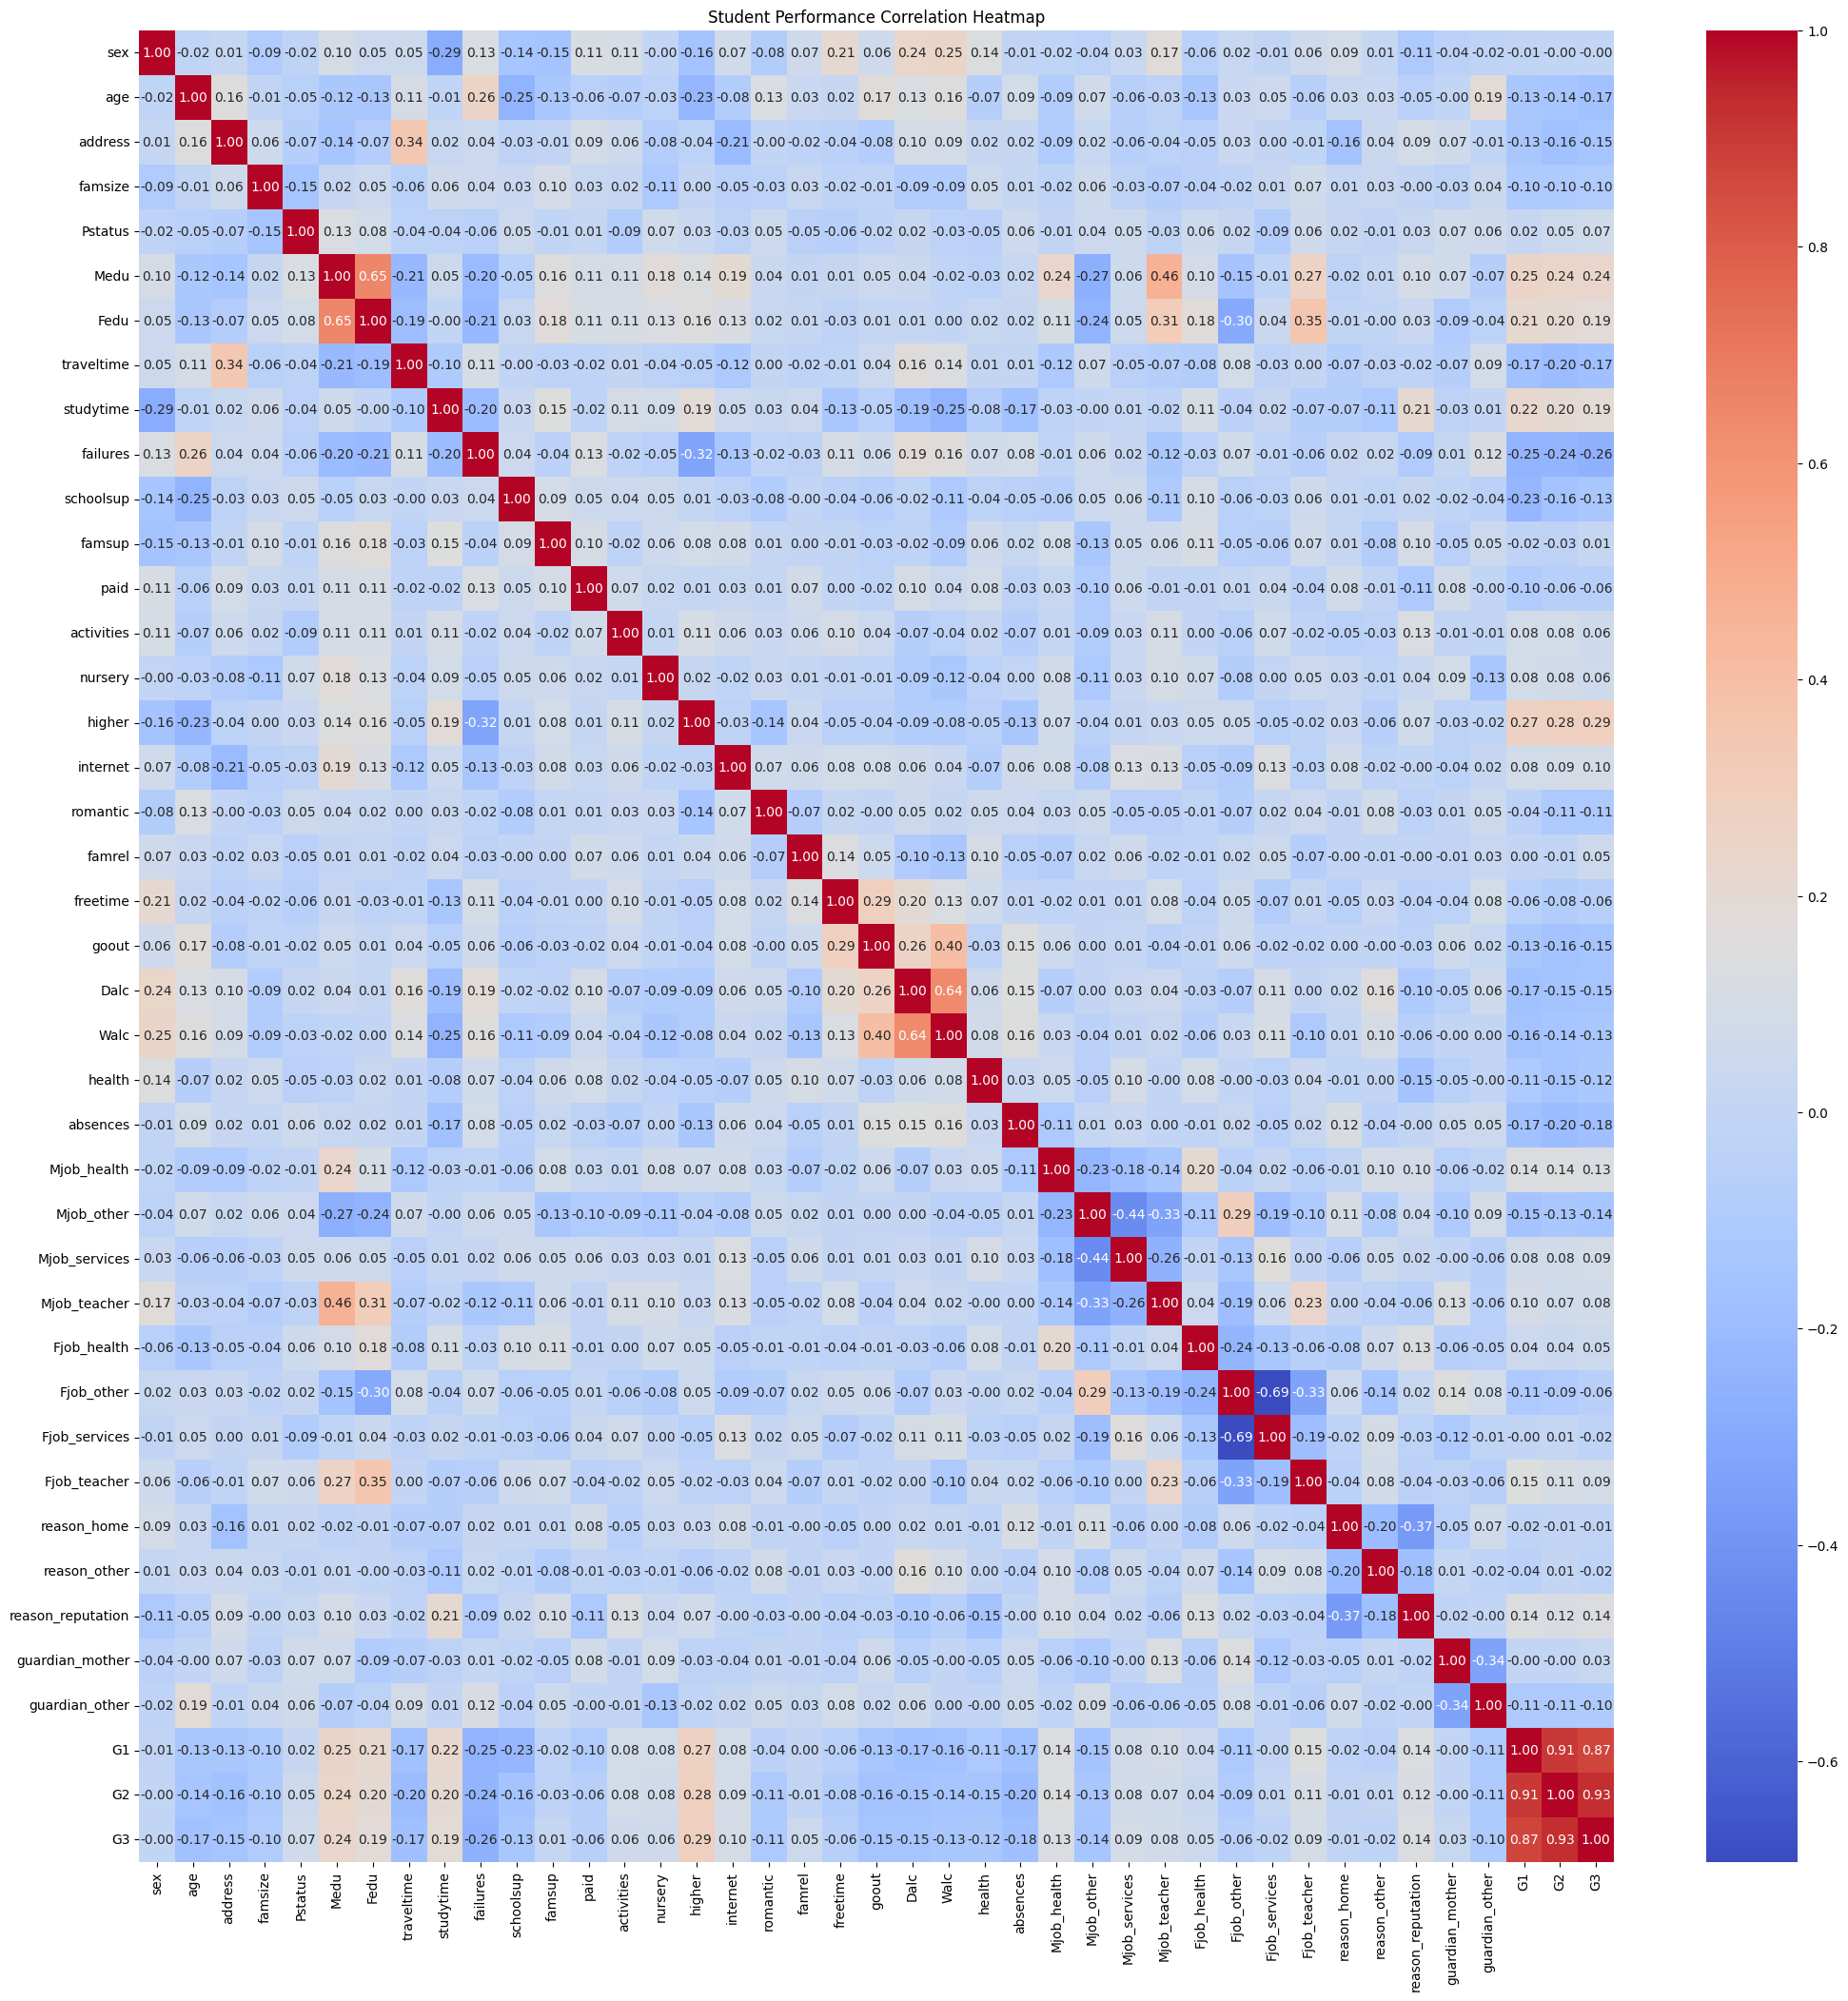

In [ ]:
plt.figure(figsize=(25, 25))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Student Performance Correlation Heatmap")
plt.show()

As we can see from the heatmap, there are many features that are decently low in terms of correlation. We plan on dropping lower correlated features, but we'll also use random forest to highlight feature importance and validate the dropped values.

RMSE: 3.167,  R²: 0.124


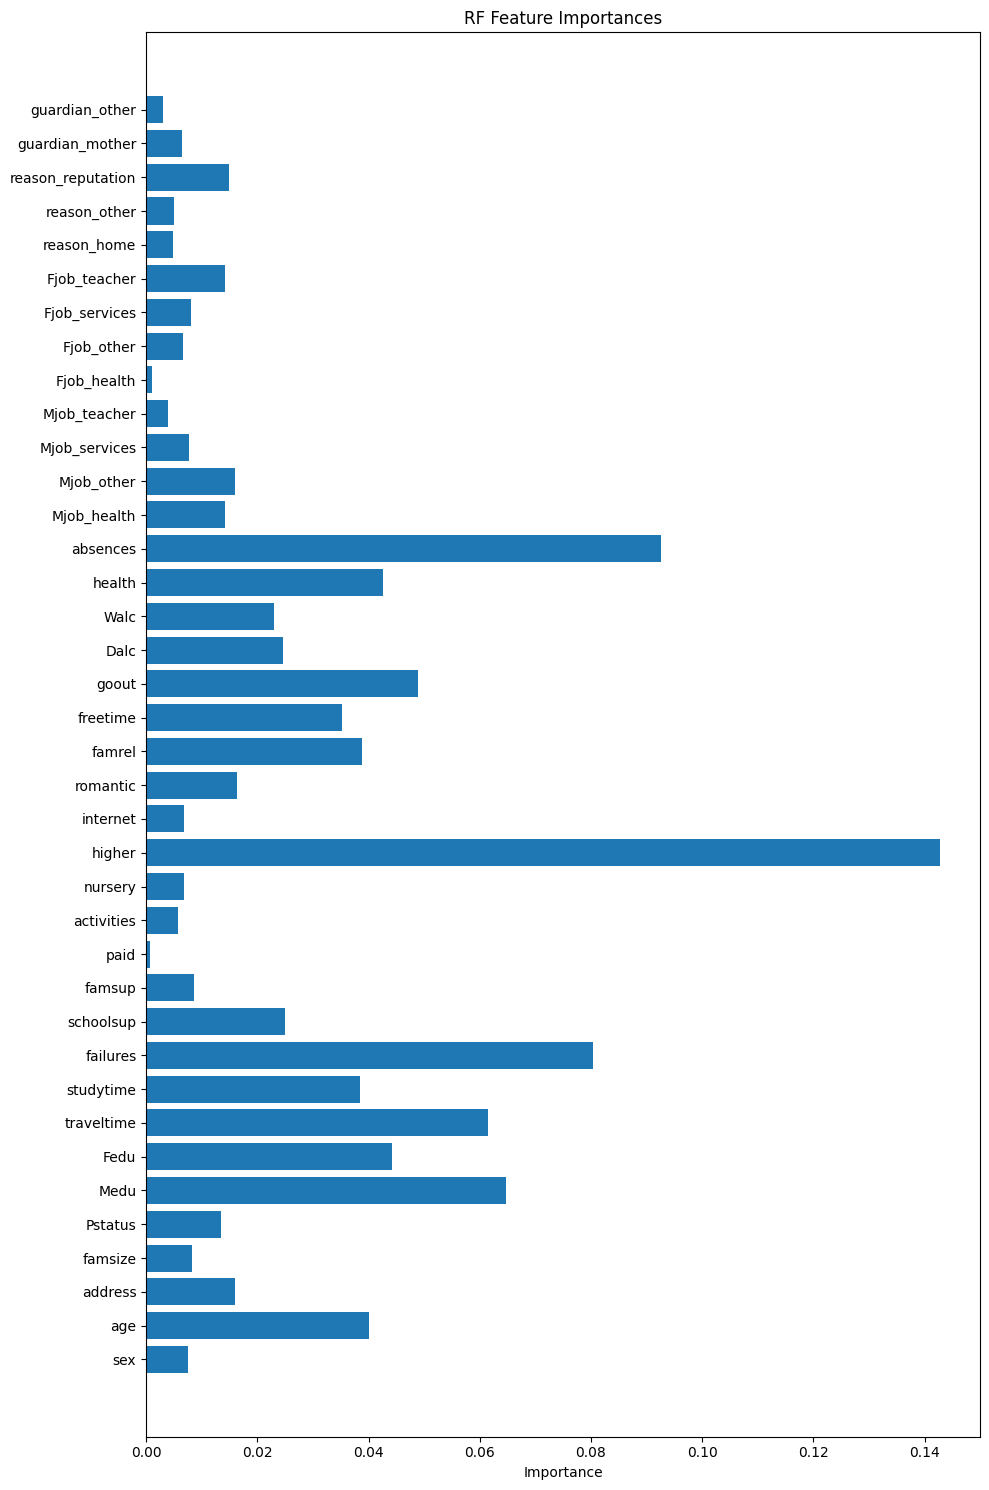

Average feature importance: 0.026


In [ ]:
# Using random forest to highlight feature importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = df.drop(columns=['G1', 'G2', 'G3'])
y = df['G3']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=100, max_depth=6, random_state=42
)
rf.fit(X_train, y_train)

# Predictions & metrics
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf  = r2_score(y_test, y_pred_rf)

print(f"RMSE: {np.sqrt(mse_rf):.3f},  R²: {r2_rf:.3f}")

# Feature importances plot
importances = rf.feature_importances_
feat_names = X.columns

plt.figure(figsize=(10, 15))
plt.barh(feat_names, importances)
plt.title("RF Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Find the average importance across all features
avg_importances = np.mean(importances)
print(f"Average feature importance: {avg_importances:.3f}")

Let's set the feature importance threshold as 0.025 since the average feature importance is 0.026, and take a look at the number of features with less than 0.025 importance.

In [ ]:
importance_threshold = 0.025

# Identify columns with low importance using threshold
low_importance_features = [col for col, importance in zip(feat_names, importances) if importance <= importance_threshold]

# Print out features with more than the threshold importance value from importances plot
print(f"Features with importance > {importance_threshold}: {sum(importances > importance_threshold)}")
for i in range(len(importances)):
    if importances[i] > importance_threshold:
        print(f"{feat_names[i]}: {importances[i]:.3f}")

print(f"Features with importance <= {importance_threshold}: {sum(importances <= importance_threshold)}")
for i in range(len(importances)):
    if importances[i] <= importance_threshold:
        print(f"{feat_names[i]}: {importances[i]:.3f}")

Features with importance > 0.025: 12
age: 0.040
Medu: 0.065
Fedu: 0.044
traveltime: 0.062
studytime: 0.039
failures: 0.080
higher: 0.143
famrel: 0.039
freetime: 0.035
goout: 0.049
health: 0.043
absences: 0.093
Features with importance <= 0.025: 26
sex: 0.008
address: 0.016
famsize: 0.008
Pstatus: 0.013
schoolsup: 0.025
famsup: 0.009
paid: 0.001
activities: 0.006
nursery: 0.007
internet: 0.007
romantic: 0.016
Dalc: 0.025
Walc: 0.023
Mjob_health: 0.014
Mjob_other: 0.016
Mjob_services: 0.008
Mjob_teacher: 0.004
Fjob_health: 0.001
Fjob_other: 0.007
Fjob_services: 0.008
Fjob_teacher: 0.014
reason_home: 0.005
reason_other: 0.005
reason_reputation: 0.015
guardian_mother: 0.006
guardian_other: 0.003


The above sections shows the feature importance before feature engineering as well. We'll then drop features that are between -0.1 to 0.1 correlation with G3, and importance lower than 0.025 (with the exception of G1 and G2).

In [ ]:
# Dropping features that are between -0.1 and 0.1 correlation with G3
correlation = df.corr()

# Extract the correlation values for the target
target_correlation = correlation['G3']

# Identify columns with weak correlation to the target
weak_coor_features = target_correlation[(target_correlation > -0.1) & (target_correlation < 0.1)].index.tolist()

df_filtered = df

# Print columns that are both in of low importance in RF and weakly correlated
print("Columns dropped due to low importance (<= 0.04), and weak correlation with 'target' (-0.1 to 0.1):")
for col in weak_coor_features:
    if col in low_importance_features:
        # Drop the column from DataFrame
        df_filtered = df_filtered.drop(columns=[col])
        print(f"- {col}")

# Confirm the new shape
print("\nNew shape of the dataset:", df_filtered.shape)
df_filtered.info()

Columns dropped due to low importance (<= 0.04), and weak correlation with 'target' (-0.1 to 0.1):
- sex
- famsize
- Pstatus
- famsup
- paid
- activities
- nursery
- Mjob_services
- Mjob_teacher
- Fjob_health
- Fjob_other
- Fjob_services
- Fjob_teacher
- reason_home
- reason_other
- guardian_mother
- guardian_other

New shape of the dataset: (382, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                382 non-null    int64  
 1   address            382 non-null    int64  
 2   Medu               382 non-null    int64  
 3   Fedu               382 non-null    int64  
 4   traveltime         382 non-null    int64  
 5   studytime          382 non-null    int64  
 6   failures           382 non-null    int64  
 7   schoolsup          382 non-null    int64  
 8   higher             382 non-null    int64  
 9   internet

Let's try running Random Forest again to check importances and see how much the average changed.

RMSE: 3.150,  R²: 0.133


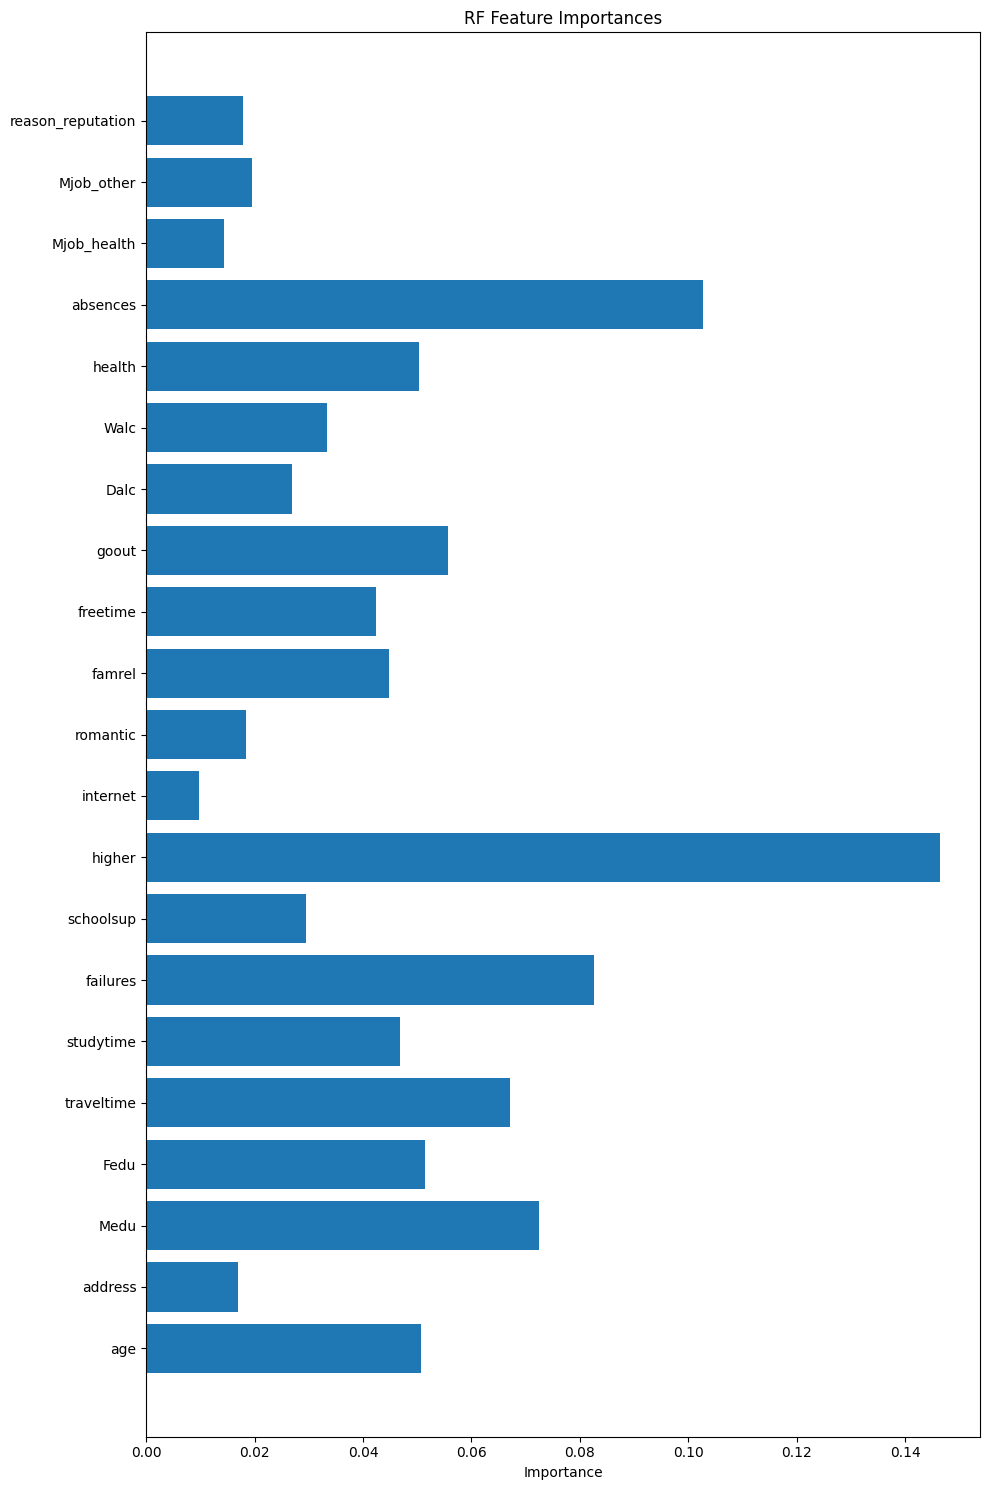

Average feature importance: 0.048


In [ ]:
# Rerunning RF on the filtered df to check importances again
X = df_filtered.drop(columns=['G1', 'G2', 'G3'])
y = df_filtered['G3']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=100, max_depth=6, random_state=42
)
rf.fit(X_train, y_train)

# Predictions & metrics
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf  = r2_score(y_test, y_pred_rf)

print(f"RMSE: {np.sqrt(mse_rf):.3f},  R²: {r2_rf:.3f}")

# Feature importances plot
importances = rf.feature_importances_
feat_names = X.columns

plt.figure(figsize=(10, 15))
plt.barh(feat_names, importances)
plt.title("RF Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Find the average importance across all features
avg_importances = np.mean(importances)
print(f"Average feature importance: {avg_importances:.3f}")

We can see that the average improved to 0.048 which is a good sign. Let's move on to feature engineering.

### Feature Engineering

For feature engineering, we plan to do the following:
- Combine mother and father education level to just parental education
- Combine weekday and weekend alcohol to total alcohol, with appropriate weight
- Drop G1 and G2 since we want to predict G3

In [ ]:
# Assign filtered df to main df for future work
df = df_filtered

In [ ]:
# Feature engineering
# Parental education from Medu and Fedu means
df['parental_edu'] = (df['Medu'] + df['Fedu']) / 2
df = df.drop(columns=['Medu', 'Fedu'])

# Total alcohol consumption
df['total_alcohol'] = (df['Dalc'] * 5/7) + (df['Walc'] * 2/7)
df = df.drop(columns=['Dalc', 'Walc'])

# Dropping G1 and G2
df = df.drop(columns=['G1', 'G2'])

# Reorder G3
g3_df = df['G3']
df = df.drop(columns=['G3'])
df['G3'] = g3_df

Let's redo Random Forest feature importance check to evaluate the new features.

RMSE: 3.143,  R²: 0.136


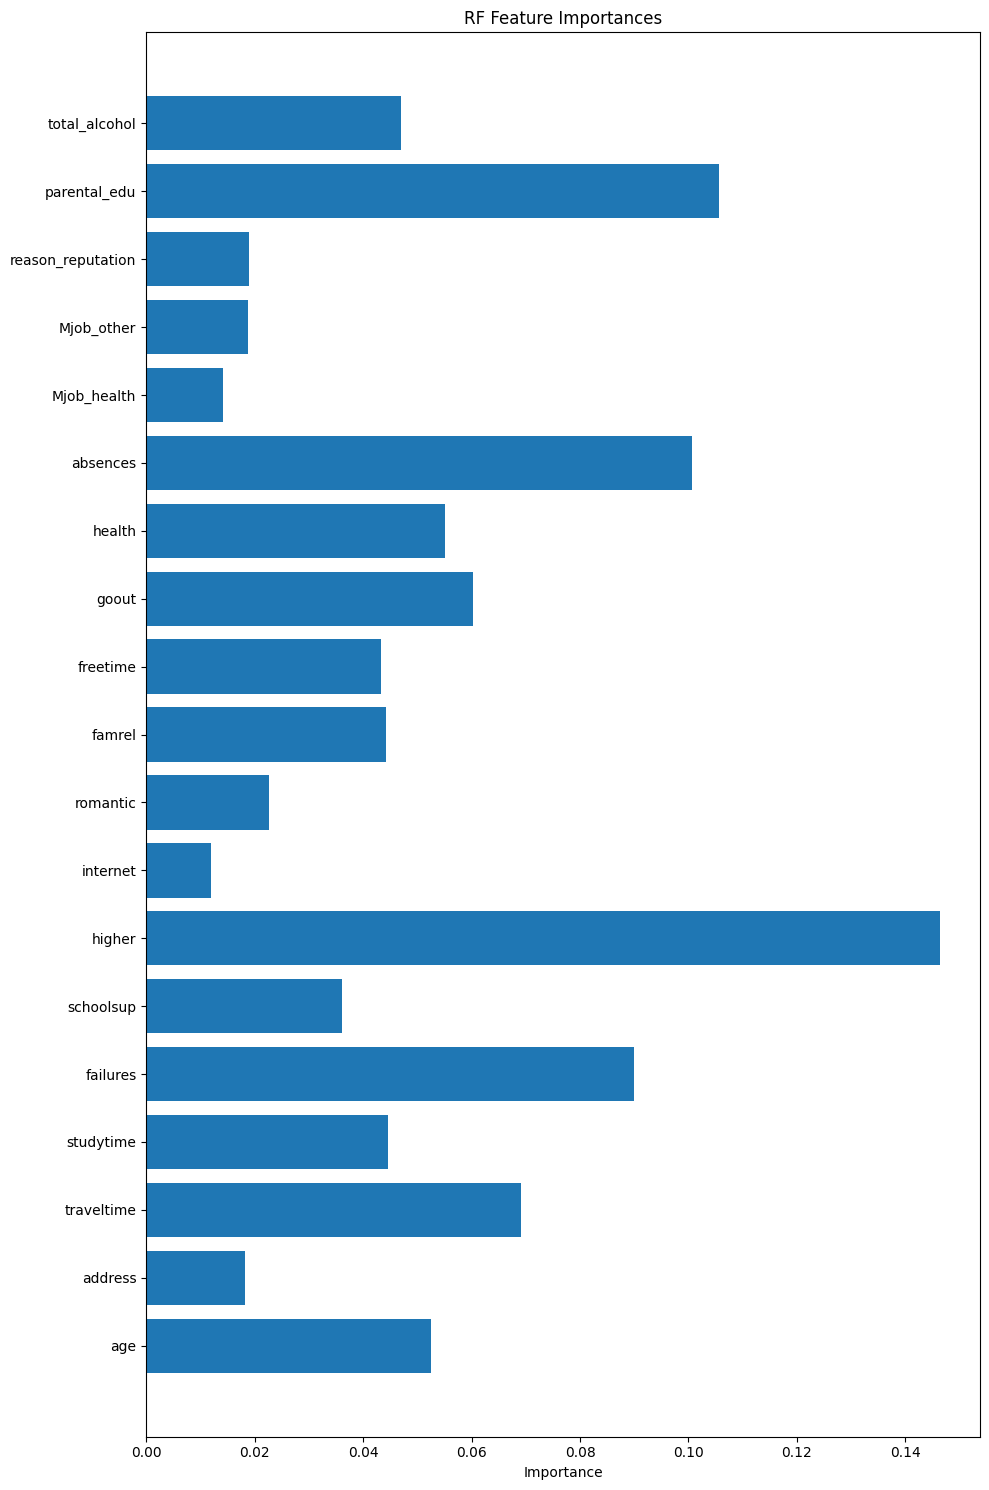

Average feature importance: 0.053


In [ ]:
# Redo RF importance check to see how important the new features are
X = df.drop(columns=['G3'])
y = df['G3']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=100, max_depth=6, random_state=42
)
rf.fit(X_train, y_train)

# Predictions & metrics
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf  = r2_score(y_test, y_pred_rf)

print(f"RMSE: {np.sqrt(mse_rf):.3f},  R²: {r2_rf:.3f}")

# Feature importances plot
importances = rf.feature_importances_
feat_names = X.columns

plt.figure(figsize=(10, 15))
plt.barh(feat_names, importances)
plt.title("RF Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Find the average importance across all features
avg_importances = np.mean(importances)
print(f"Average feature importance: {avg_importances:.3f}")

We can see that the feature importance average increased to 0.053, and total_alcohol and parental_edu are also decently high in importance.
Average feature importance timeline:
- Original dataset: 0.026
- Dataset after dropping lower importance and coor features: 0.048
- Dataset after dropping lower importance and coor features, and with feature engineering: 0.053

### Visualizations

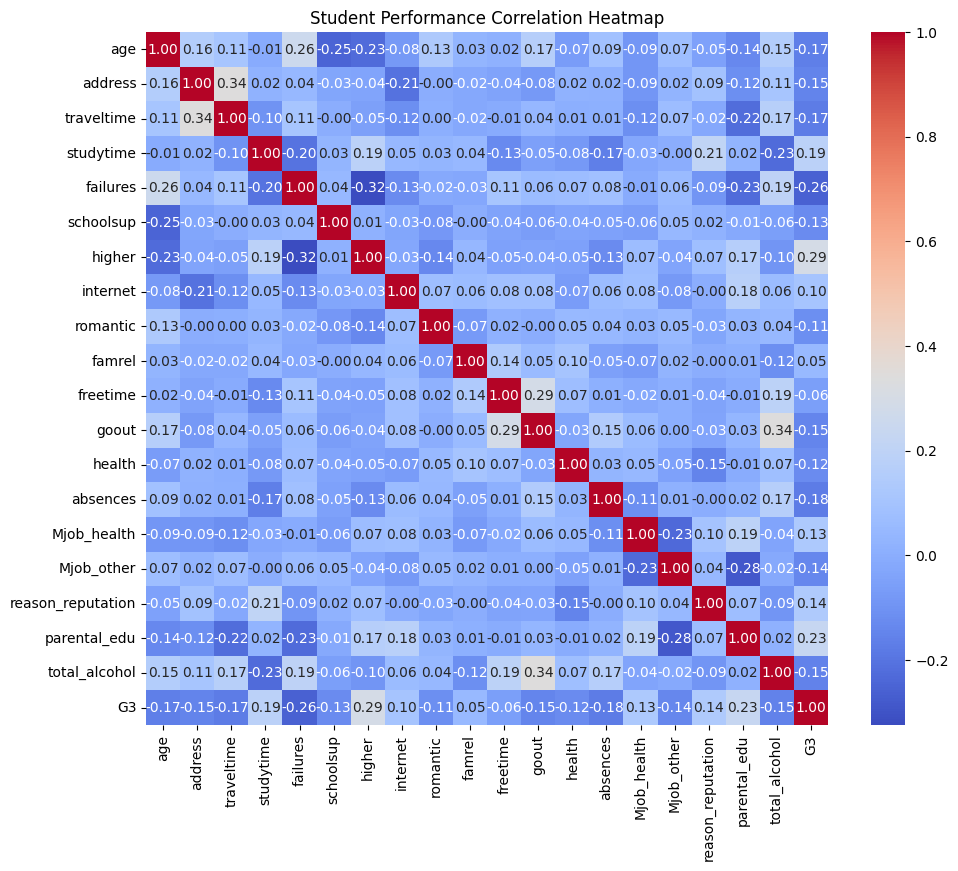

In [ ]:
# Replot after dropping lower correlated columns and feature engineering
plt.figure(figsize=(11, 9))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Student Performance Correlation Heatmap")
plt.show()

The new correlation heatmap is much more interpretable now that many uncorrelated and non Random Forest important features have been removed. Across the board there is little correlation with features. On one hand there is very little multicollinearity but also correlation with G3.

In [ ]:
X = add_constant(df.drop('G3', axis=1))
X = X.select_dtypes(include=np.number)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("Variance Inflation Factor:\n", vif)

Variance Inflation Factor:
          Variable         VIF
0           const  357.672508
1             age    1.303616
2         address    1.222447
3      traveltime    1.216211
4       studytime    1.161851
5        failures    1.303236
6       schoolsup    1.095526
7          higher    1.222440
8        internet    1.136248
9        romantic    1.066139
10         famrel    1.081914
11       freetime    1.166139
12          goout    1.283946
13         health    1.061716
14       absences    1.082406
15   parental_edu    1.154199
16  total_alcohol    1.337541


Checking for multicollinearity again, all features are well below 10.

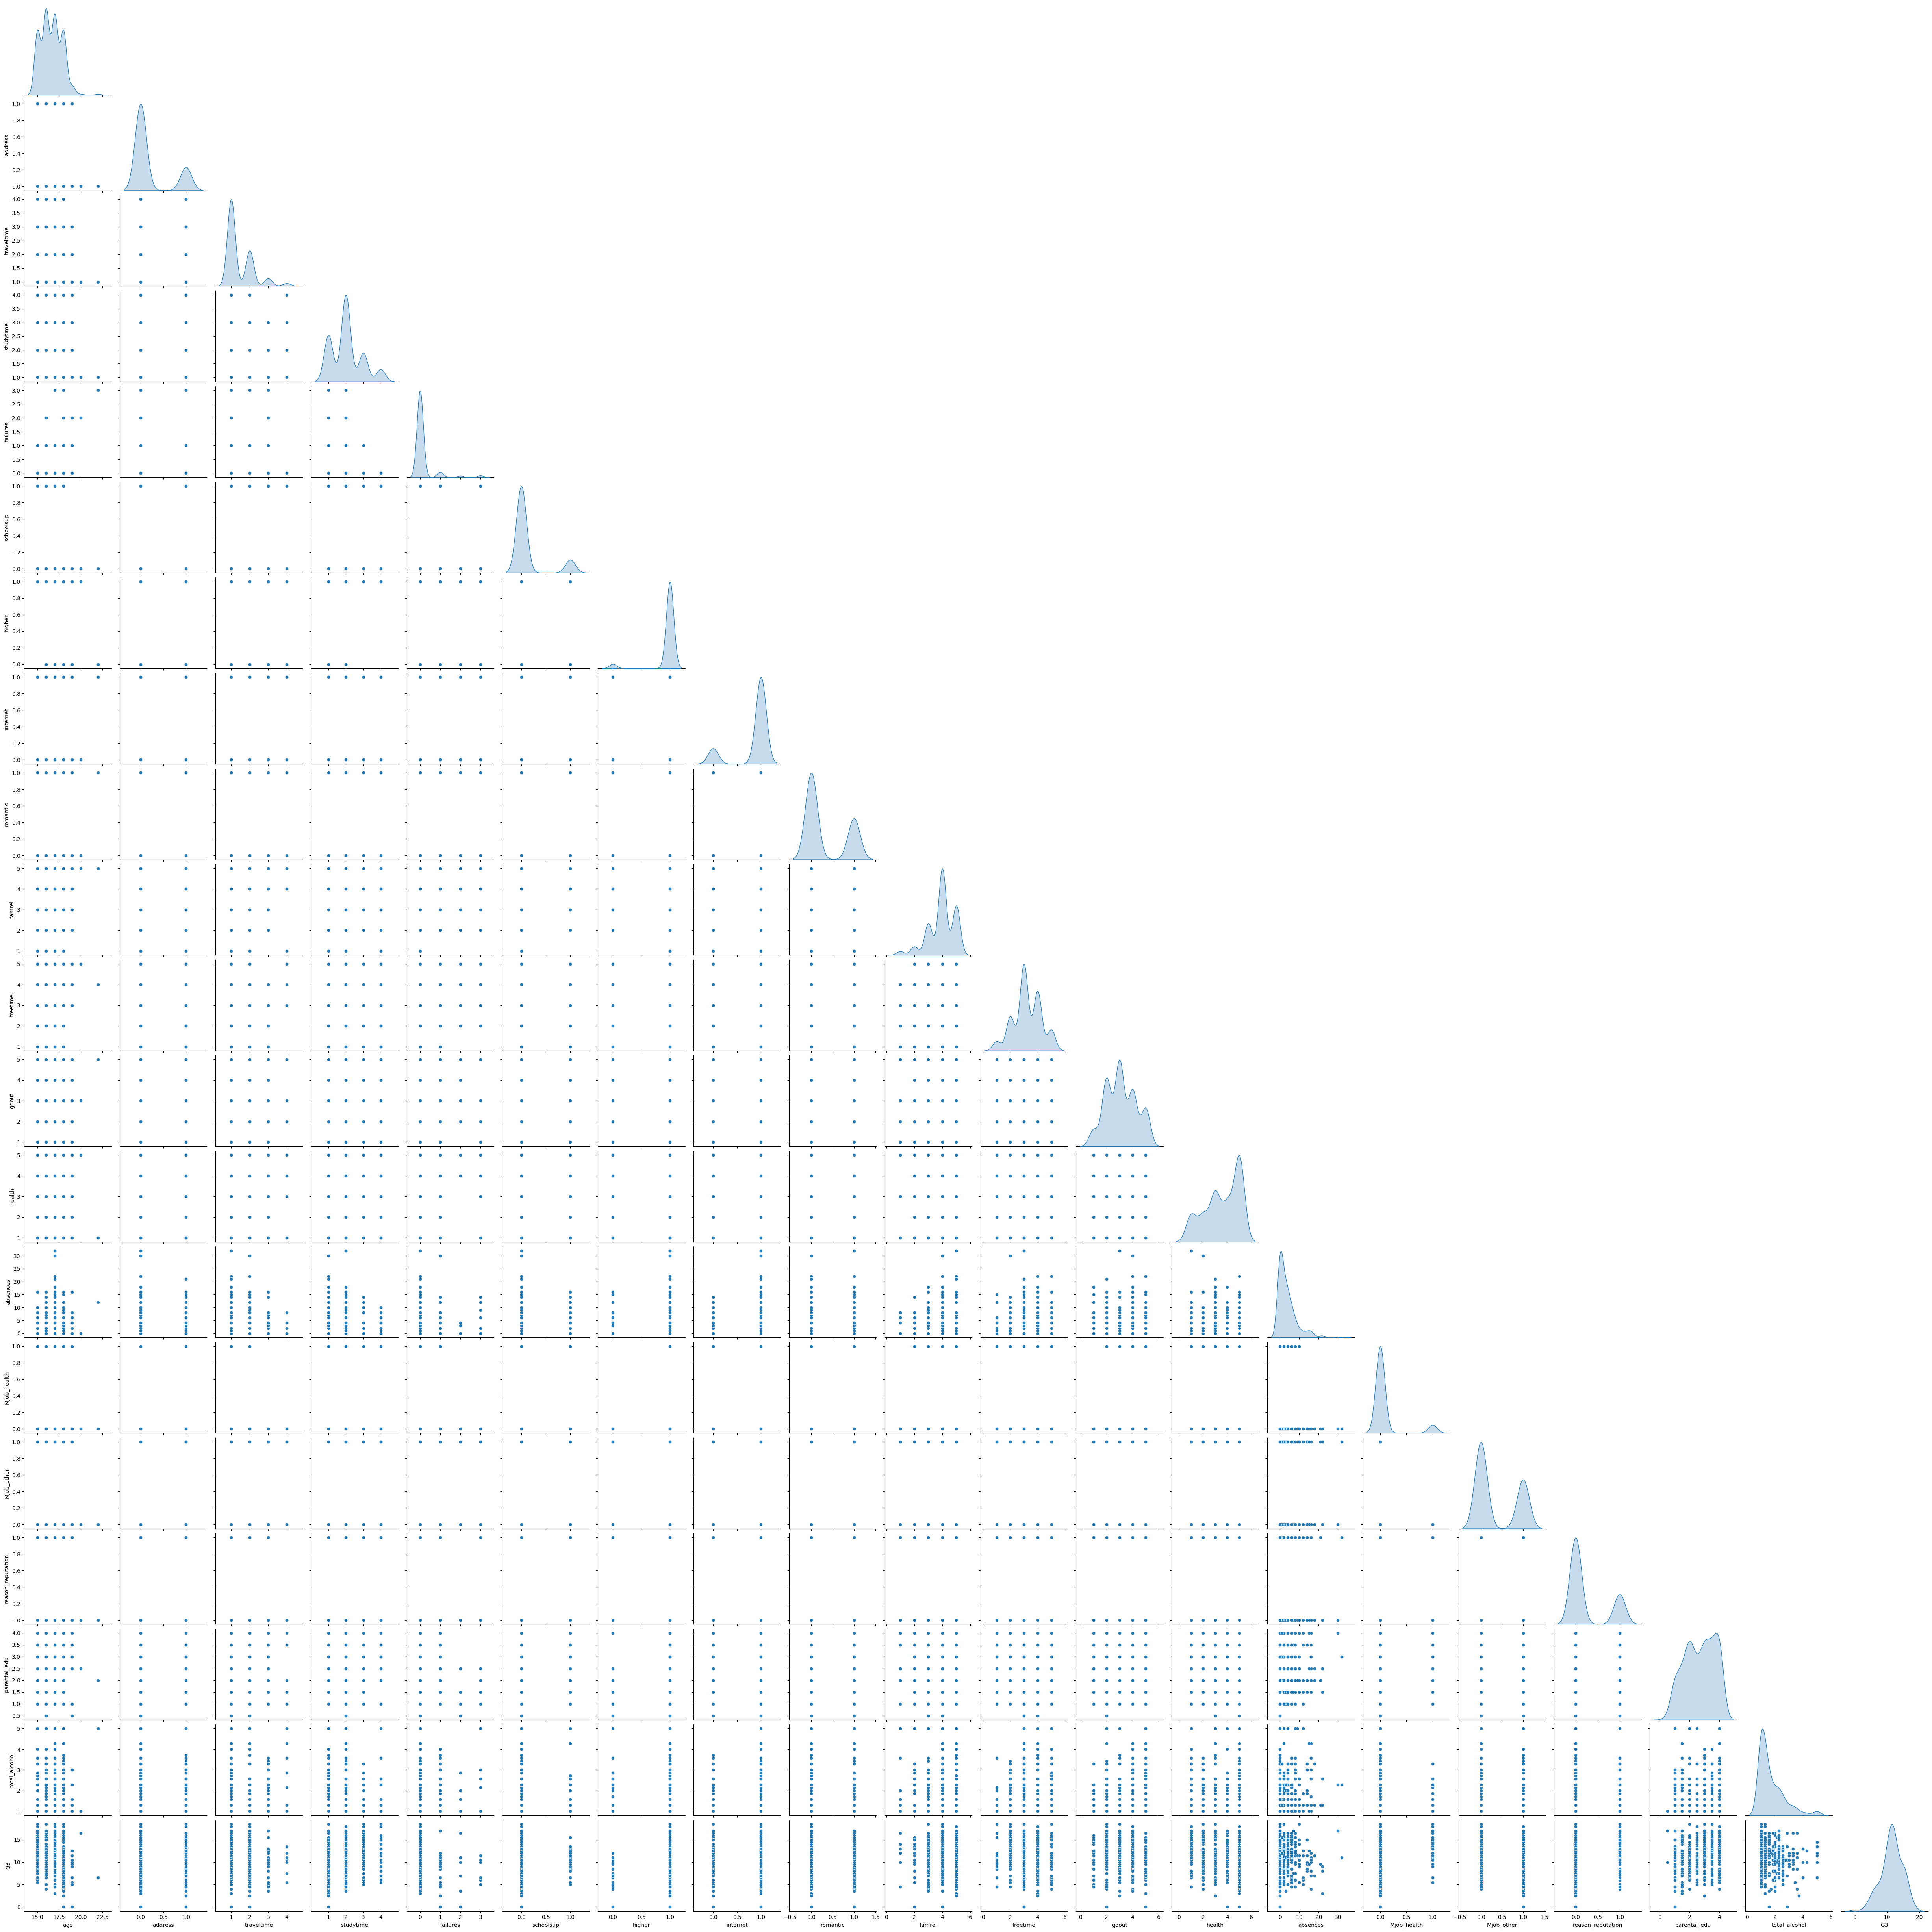

In [ ]:
sns.pairplot(df, diag_kind="kde", markers="o", corner=True)
plt.show()

While the pairplot is much too large to go into depth, it reinforces the correlation heatmap with there being no clear correlation between G3 and other features.

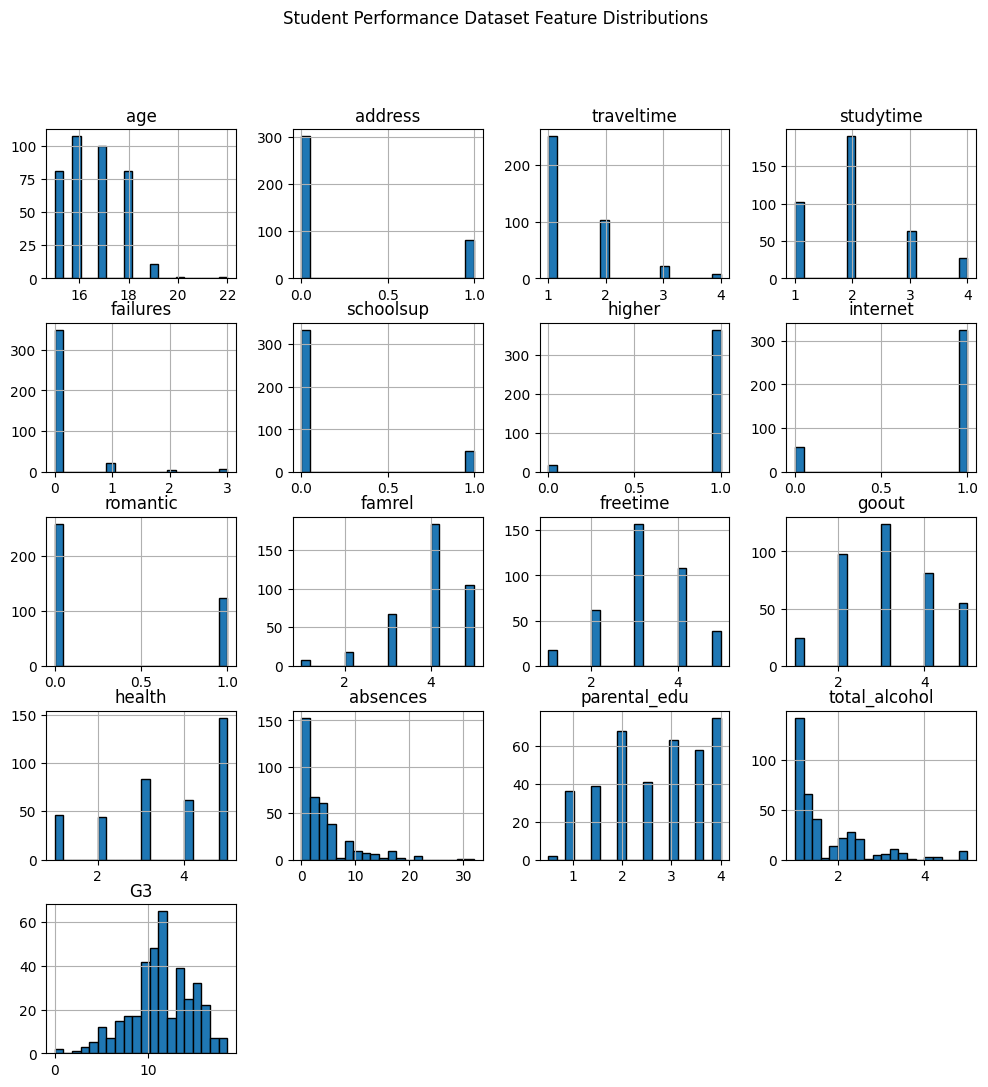

In [ ]:
df.hist(figsize=(12, 12), bins=20, edgecolor="black")
plt.suptitle("Student Performance Dataset Feature Distributions")
plt.show()

G3's distribution is mostly normal with a slight right skew. The more important takeaway from these graphes is the jumps in distributions. For features such as romantic or schoolsup they are binary but contain big jumps that might help CART models. Other features are incedibly skewed such as total_alcohol and absences that could help in a similar vein. In particular failures and higher have the vast majority of their distribution in one class and have a relatively high correlation with G3. This could indicate those less populated classes can have an outsized impact on predicting G3.

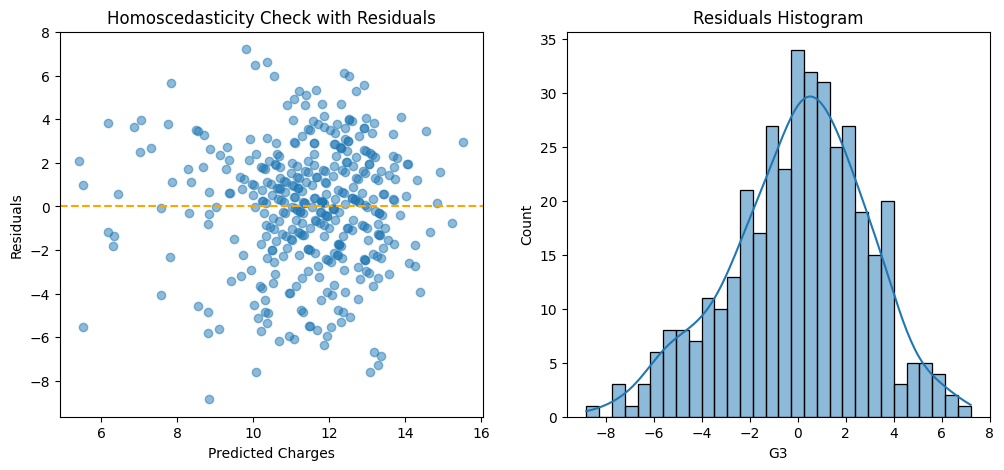

In [ ]:
X = df.drop(columns=["G3"], axis=1)
y = df["G3"]

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

residuals = y - y_pred

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(y_pred, residuals, alpha=0.5)
ax[0].axhline(y=0, color="orange", linestyle="--")
ax[0].set_xlabel("Predicted Charges")
ax[0].set_ylabel("Residuals")
ax[0].set_title("Homoscedasticity Check with Residuals")

sns.histplot(residuals, bins=30, kde=True)
ax[1].set_title("Residuals Histogram")

plt.show()

Checking for linearity, this dataset is a good candidate for linear regression. The residuals are randomly scattered and the histogram is only slightly right skewed.

## Models

We used both regression and classification models, with the models listed below:

Regression:
- Linear Regression
- Polynomial Regression
- Random Forest Regressor w/ Boosting
- LASSO Regression

Classification:
- Decision Tree Classifier
- Logistic Regression
- Random Forest Classifier
- Gradient Boosting
- XGBoost

### Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['G3'], axis=1), df['G3'], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

y_lin_pred = lin_reg.predict(X_test_scaled)

lin_r2 = lin_reg.score(X_test_scaled, y_test)
lin_rmse = np.sqrt(mean_squared_error(y_test, y_lin_pred))

print(f"Linear Regression R^2: {lin_r2}")
print(f"Linear Regression RMSE: {lin_rmse}")

Linear Regression R^2: 0.1410201878309062
Linear Regression RMSE: 3.1350095753575595


Best Polynomial Degree: 1
R^2: 0.1410201878309062
RMSE: 2.98646003944092


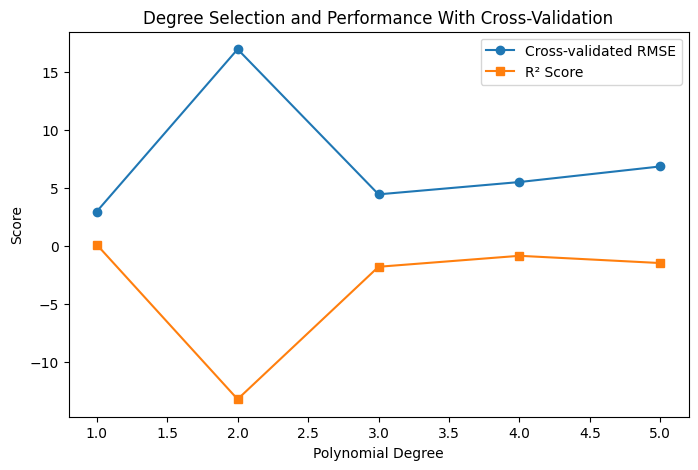

In [ ]:
def poly_regression(X_train, y_train, X_test, y_test, use_plot):
  degrees = range(1, 6)
  rmse_scores = []
  r2_scores = []

  for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), LinearRegression())
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

    rmse = np.mean(np.sqrt(-scores))
    model.fit(X_train, y_train)
    r2 = model.score(X_test, y_test)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

  print(f"Best Polynomial Degree: {degrees[np.argmin(rmse_scores)]}")
  print(f"R^2: {r2_scores[np.argmin(rmse_scores)]}")
  print(f"RMSE: {rmse_scores[np.argmin(rmse_scores)]}")

  if use_plot:
    plt.figure(figsize=(8,5))
    plt.plot(degrees, rmse_scores, marker='o', label="Cross-validated RMSE")
    plt.plot(degrees, r2_scores, marker='s', label="R² Score")
    plt.xlabel("Polynomial Degree")
    plt.ylabel("Score")
    plt.title("Degree Selection and Performance With Cross-Validation")
    plt.legend()
    plt.show()

poly_regression(X_train_scaled, y_train, X_test_scaled, y_test, True)

In [ ]:
# Train Random Forest
rf = RandomForestRegressor(
    n_estimators=100, max_depth=6, random_state=42
)
rf.fit(X_train, y_train)

# Predictions & metrics
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf  = r2_score(y_test, y_pred_rf)

print(f"RF → RMSE: {np.sqrt(mse_rf):.3f},  R²: {r2_rf:.3f}")

RF → RMSE: 3.143,  R²: 0.136


In [ ]:
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    print(f"Trained {name}")

Trained RandomForest
Trained GradientBoosting
Trained XGBoost


In [ ]:
results = {}
for name, mdl in models.items():
    preds = mdl.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2  = r2_score(y_test, preds)
    print(f"{name} RMSE: {np.sqrt(mse):.3f},  R²: {r2:.3f}\n")

RandomForest RMSE: 3.228,  R²: 0.089

GradientBoosting RMSE: 3.191,  R²: 0.110

XGBoost RMSE: 3.720,  R²: -0.209



In [ ]:
poly = PolynomialFeatures(1, include_bias=False)

X_train_poly_scaled = poly.fit_transform(X_train_scaled)
X_test_poly_scaled = poly.transform(X_test_scaled)

lasso = LassoCV(alphas=np.logspace(-3, 3, 100), cv=5, max_iter=50000)
lasso.fit(X_train_poly_scaled, y_train)

# Predictions & Evaluation
y_lasso_pred = lasso.predict(X_test_poly_scaled)
lasso_r2 = lasso.score(X_test_poly_scaled, y_test)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_lasso_pred))

print(f"Lasso Polynomial Regression R²: {lasso_r2:.4f}")
print(f"Lasso Polynomial Regression RMSE: {lasso_rmse:.4f}")

# Identify features removed by Lasso
lasso_coefs = pd.Series(lasso.coef_, index=poly.get_feature_names_out(X_train.columns))
removed_features = lasso_coefs[lasso_coefs == 0].index.tolist()

print(f"\nFeatures Removed by Lasso: {removed_features}")

Lasso Polynomial Regression R²: 0.1381
Lasso Polynomial Regression RMSE: 3.1403

Features Removed by Lasso: ['freetime', 'total_alcohol']


The regression models performed terribly with R² scores of around 0.1-0.15 and RMSE scores of around 3. With average differences of 3 and so little of the variance being able to be captured by the models, we pivoted to using classification models.

### Classification

We opted to use Logistic Regression, Decision Tree Classifier, Random Forest, Gradient Boosting, and XGBoost. The classification models performed much better than the regression models.

In [ ]:
tree_df = df.copy()

# Remove outliers
per_95 = np.percentile(tree_df['G3'], 95)
per_5 = np.percentile(tree_df['G3'], 5)
tree_df = tree_df[(per_5 <= tree_df['G3']) & (tree_df['G3'] <= per_95)]

# Categorize G3 into pass and fail
tree_df['knowledge_gain'] = np.where(tree_df['G3'] >= 10, 1, 0)
tree_df = tree_df.drop(columns=['G3'])

X = tree_df.drop('knowledge_gain', axis=1)
y = tree_df['knowledge_gain']

# Oversample the Fails to remove imbalance
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Train test split on tree_df
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    stratify=y_resampled,
    random_state=42
)

We've preprocessed the dataset to increase model performance and convert it for classification use. First, the G3 target is transformed into knowledge_gain where a G3 score of 10 or higher is converted to a Pass and anything less is a Fail. Second, 5th and 95th percentile outliers are removed to increase boosting performance. Last, since the Pass class is oversampled we use RandomOverSampler to oversample Fail in turn to prevent a class imbalance.

In [ ]:
param_grid_dtc = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

param_grid_rfc = {
    'n_estimators': [50, 100, 300, 500],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

param_grid_gb = {
    'n_estimators': [50, 100, 300, 500],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'learning_rate': [1, 0.1, 0.01, 0.001],
}

param_grid_xgb = {
    'n_estimators': [50, 100, 300, 500],
    'max_depth': [None, 2, 5, 10],
    'learning_rate': [1, 0.1, 0.01, 0.001],
}

# Find the best hyperparameters for every model
gs_dtc = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dtc, cv=5, n_jobs=-1, scoring='f1')
gs_rfc = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rfc, cv=5, n_jobs=-1, scoring='f1')
gs_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, n_jobs=-1, scoring='f1')
gs_xgb = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid_xgb, cv=5, n_jobs=-1, scoring='f1')

In [ ]:
gs_dtc.fit(X_train, y_train)

print("Best Decision Tree parameters:", gs_dtc.best_params_)

Best Decision Tree parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
gs_rfc.fit(X_train, y_train)

print("Best Random Forest parameters:", gs_rfc.best_params_)

Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
gs_gb.fit(X_train, y_train)

print("Best Gradient Boosting parameters:", gs_gb.best_params_)

Best Gradient Boosting parameters: {'learning_rate': 0.1, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}


In [ ]:
gs_xgb.fit(X_train, y_train)

print("Best XGB parameters:", gs_xgb.best_params_)

Best XGB parameters: {'learning_rate': 1, 'max_depth': 10, 'n_estimators': 500}


In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the logistic regression model
log = LogisticRegression(random_state=42)
log.fit(X_train_scaled, y_train)

# Predict class labels on the test set
log_y_pred = log.predict(X_test_scaled)

# Calculate and print accuracy
log_accuracy = accuracy_score(y_test, log_y_pred)
print("Test Accuracy:", log_accuracy)

# Display the confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_test, log_y_pred))
print("Classification Report:\n", classification_report(y_test, log_y_pred))

Test Accuracy: 0.5833333333333334
Confusion Matrix:
 [[37 17]
 [28 26]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.69      0.62        54
           1       0.60      0.48      0.54        54

    accuracy                           0.58       108
   macro avg       0.59      0.58      0.58       108
weighted avg       0.59      0.58      0.58       108



Here we've tried out logistic regression to compare with the decision tree and ensemble methods. We will discuss their performance soon, but this model performed poorly compared to them in every metric. It serves as a baseline to the later model's performance.

In [ ]:
# Initialize models with ideal hyperparameters
models = {
    'DecisionTree': DecisionTreeClassifier(
        criterion='gini',
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=2,
        random_state=42),
    'RandomForest': RandomForestClassifier(
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=300,
        random_state=42),
    'GradientBoosting': GradientBoostingClassifier(
        max_depth=10,
        min_samples_leaf=4,
        min_samples_split=10,
        n_estimators=300,
        learning_rate=0.1,
        random_state=42),
    'XGBoost': xgb.XGBClassifier(
        eval_metric='logloss',
        n_estimators=500,
        learning_rate=1,
        max_depth=10,
        #subsample=1,
        random_state=42)
}

# Train models
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    print(f"Trained {name}")

Trained DecisionTree
Trained RandomForest
Trained GradientBoosting
Trained XGBoost


In [ ]:
# Predict with models and compare results
results = {}
for name, mdl in models.items():
    preds = mdl.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    results[name] = acc


DecisionTree Accuracy: 0.8981
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        54
           1       1.00      0.80      0.89        54

    accuracy                           0.90       108
   macro avg       0.92      0.90      0.90       108
weighted avg       0.92      0.90      0.90       108

Confusion Matrix:
 [[54  0]
 [11 43]]

RandomForest Accuracy: 0.9444
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        54
           1       1.00      0.89      0.94        54

    accuracy                           0.94       108
   macro avg       0.95      0.94      0.94       108
weighted avg       0.95      0.94      0.94       108

Confusion Matrix:
 [[54  0]
 [ 6 48]]

GradientBoosting Accuracy: 0.9074
              precision    recall  f1-score   support

           0       0.84      1.00      0.92        54
           1       1.00      0.81      0.90        54

    accur

We will go into more depth on accuracy in the next block, but with the classifcation report all the models performed exceptionally well in terms of recall for Fail and precision for Pass. All models' predictions when it came to it were perfect, only suffering on precision for Fail and recall for Pass. In terms of F1 scores the models from worst to best are Decision Tree, Gradient Boosting, XGBoost, and Random Forest.

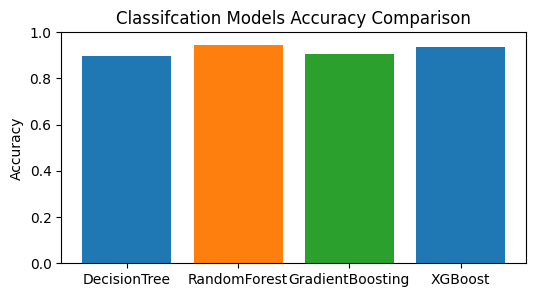

In [ ]:
plt.figure(figsize=(6,3))
plt.bar(results.keys(), results.values(), color=['C0','C1','C2'][:len(results)])
plt.ylim(0,1)
plt.title("Classifcation Models Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

As a whole the four models are similar in accuracy, hovering around or above 90%. Random Forest and XGBoost stand out still with the highest accuracies of 94.4% and 93.5% respectively.

## Results

Here is the feature importances of our best model, random forest, graphed. The highest and most important feature to prediction was higher or the student's desire for higher education. There were also high demographic features such as address or parental_edu, but many were also personal choices a student had impact over such as absences or studytime.

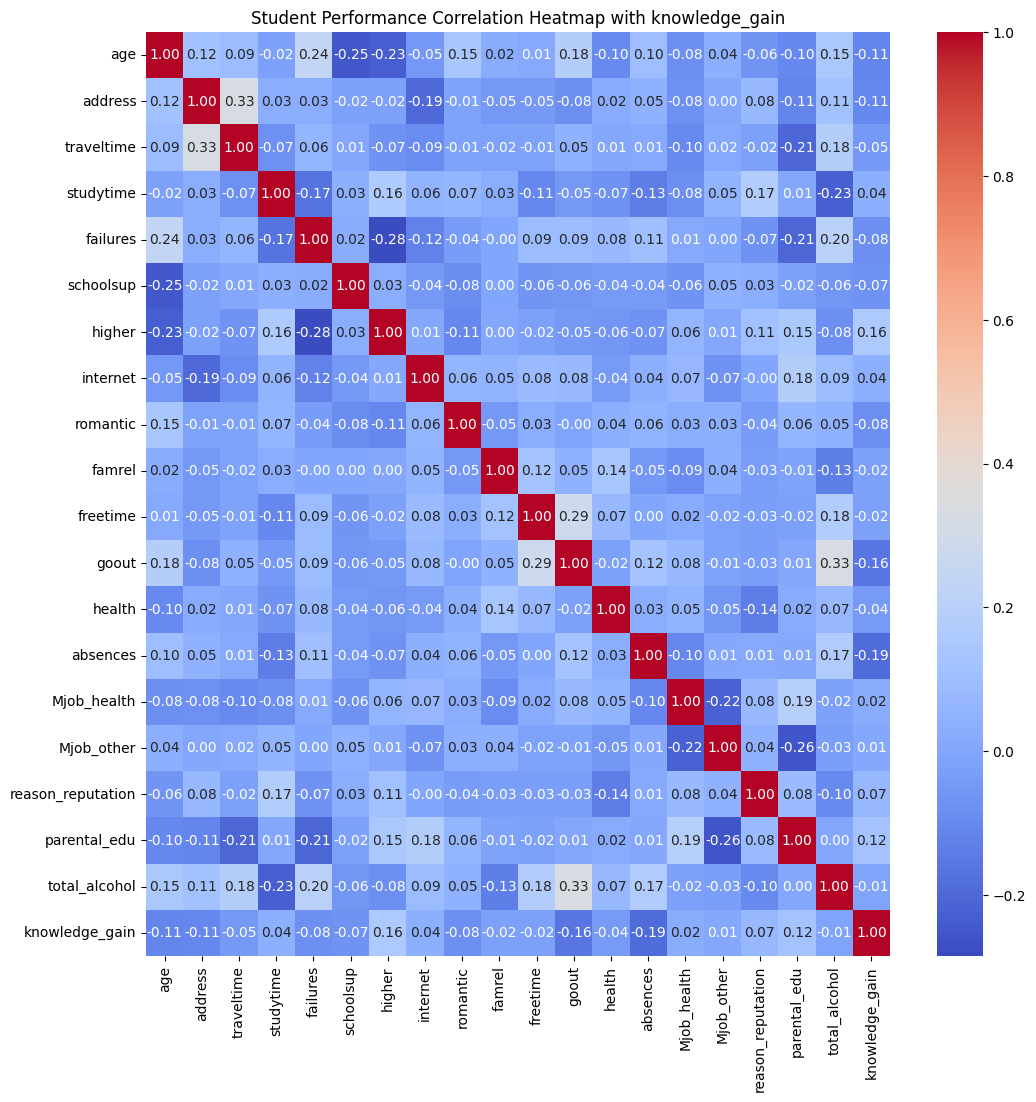

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(tree_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Student Performance Correlation Heatmap with knowledge_gain")
plt.show()

The transformation from G3 to knowledge_gain made little practical difference with its feature correlation still remaining low across the board.

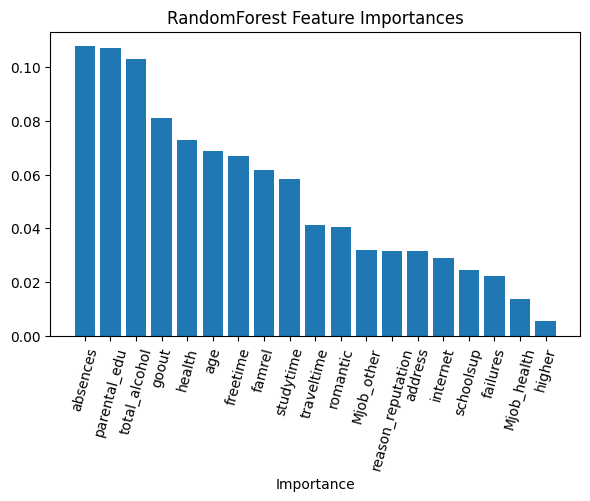

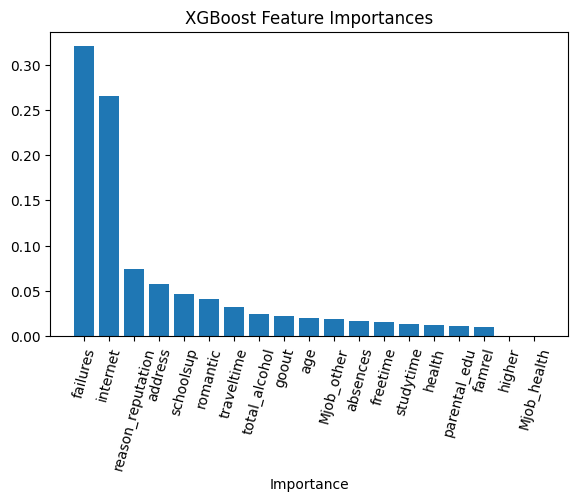

In [ ]:
best_models = {'RandomForest': models['RandomForest'], 'XGBoost': models['XGBoost']}
for name, mdl in best_models.items():
  importances = mdl.feature_importances_
  feat_names = X.columns
  importance_df = pd.DataFrame({'feat_names': feat_names, 'importances': importances})
  importance_df = importance_df.sort_values(by='importances', ascending=False)

  plt.figure(figsize=(6, 4))
  plt.bar(importance_df['feat_names'], importance_df['importances'])
  plt.title(f"{name} Feature Importances")
  plt.xlabel("Importance")
  plt.tight_layout()
  plt.xticks(rotation=75)
  plt.show()

From our two best models, Random Forest and Extreme Gradient Boosting, we can see our most important features for prediction. For Extreme Gradient Boosting, the two overwhelmingingly important features are failures and internet, taking over 50% of the feature importance. Random Forest is more balanced but among the top features are absences, parental_edu, and total_alchohol.

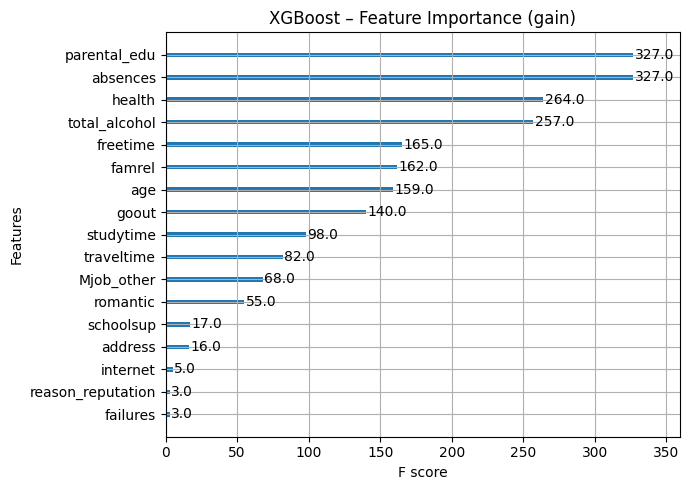

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
xgb.plot_importance(models['XGBoost'], ax=ax)
plt.title("XGBoost – Feature Importance (gain)")
plt.tight_layout()
plt.show()

Here we can see the features that were influential to Extreme Gradient Boosting's splitting process. The top two and contested features are parental_edu and absences at 327.0 F score, with health and total_alcohol trailing behind.

## Conclusion

Overall, our classifcation models performed well in predicting student performance with our dataset, with Extreme Gradient Boosting and Random Forest turning out to be our best models. Using their feature importances and feature importance gains we conclude that the top five most important factors for a student's performance we can find were failures the student has in the past, internet access, absences, education level of parents, and total alcohol consumption. Therefore, these are the four factors, aside from parental education, that from our analysis, we recommend students to focus and improve upon if they want to better their academic performance.